In [258]:

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from backbone import *
import matplotlib.pyplot as plt
import math
# from torchvision.references.detection.engine import train_one_epoch, evaluate

In [259]:
sc_model = StrokeClassifier(img_dims=(224, 224))
sc_model.load_state_dict(torch.load("backbone.pt"))
sc_model.eval()


StrokeClassifier(
  (features): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  )
  (head): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2592, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=4, bias=True)
  )
)

In [260]:
# load a pre-trained model for classification and return
# only the features
backbone = sc_model.features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 32

In [261]:
# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be ['0']. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=9,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=4,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler,
#                    box_head=sc_model.head,
                   image_mean=[0],
                   image_std=[1],
)



In [263]:
base = data["base"]
for i in range(3):
    item = data[STROKES[random.randint(0, 3)]]
    base, coord_labels = img_lib.do_transform_vanilla(item["img"], np.array([item["start"],item["end"]]), base)

In [264]:
def prep_tensor(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)[:,:,None]
#     print(img.shape)
    img = img.transpose(2,0,1)
    return torch.Tensor(img/255).unsqueeze(0)

In [265]:
img.shape

(290, 615, 3)

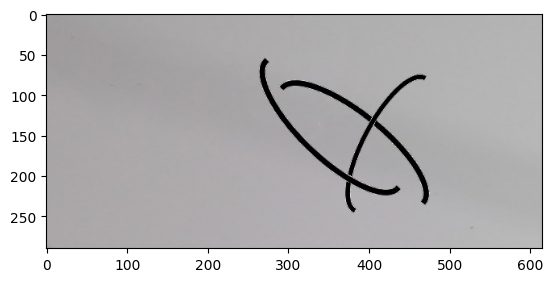

In [266]:
plt.imshow(base)

In [267]:
mean = torch.as_tensor([0], dtype=torch.float32)
std = torch.as_tensor([1], dtype=torch.float32)
out = (x - mean[:, None, None]) / std[:, None, None]
out.shape

torch.Size([1, 1, 290, 615])

In [268]:
model.eval()
x = prep_tensor(base)
print(x.shape)
predictions = model(x)

torch.Size([1, 1, 290, 615])


In [269]:
def draw_boxes(boxes, classes, labels, image):
    # read the image with OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [270]:
import pickle
import random

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

import img as img_lib

import importlib
importlib.reload(img_lib)
class RCNNImgDataset(Dataset):
    def __init__(self, data_path, strokes, size=(224, 224), augmentation=None, return_coords=False, length=1000, min_strokes=2, max_strokes=5):
        with open(data_path, "rb") as f:
            self.data = pickle.load(f)
        self.return_coords = return_coords
        self.augmentation = augmentation
        self.size = size
        self.strokes = strokes
        self.length = length
        self.min_strokes = min_strokes
        self.max_strokes = max_strokes
        
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
        bbox_labels = []
        n_strokes = random.randint(self.min_strokes, self.max_strokes)
        labels = []
        img = self.data["base"]
        for i in range(n_strokes):
            item = self.data[self.strokes[random.randint(0, len(self.strokes) - 1)]]
            stroke = item["img"]
            transform_coords = np.array([[0, 0],[0, stroke.shape[1]],[stroke.shape[0], 0],[stroke.shape[0], stroke.shape[1]]])
            img, coord_labels = img_lib.do_transform_vanilla(stroke, transform_coords, img)
            bbox_labels.append([
                min(coord_labels[:,1]),
                min(coord_labels[:,0]),
                max(coord_labels[:,1]),
                max(coord_labels[:,0]),
            ])
            labels.append(item["label"])
        img = img[:,:,:3].transpose(2,0,1)
        if self.augmentation is not None:
            img = self.augmentation(torch.Tensor(img)/255) * 255
            img = img.numpy()
        img = img_lib.remove_bg(img.transpose(1,2,0).astype(np.uint8), self.data["base"])
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        out_label = {
            "boxes": torch.Tensor(bbox_labels),
            "labels": torch.Tensor(labels).type(torch.int64),
        }
        return torch.Tensor(img/255).unsqueeze(2).permute(2,0,1), out_label

In [271]:
train_ds[0]

(tensor([[[0.0000, 0.0039, 0.0000,  ..., 0.0941, 0.0980, 0.0941],
          [0.0000, 0.0000, 0.0000,  ..., 0.0980, 0.0980, 0.0902],
          [0.0000, 0.0000, 0.0000,  ..., 0.0980, 0.0941, 0.0902],
          ...,
          [0.0000, 0.0392, 0.0627,  ..., 0.1059, 0.1020, 0.1020],
          [0.0000, 0.0000, 0.0510,  ..., 0.0980, 0.1020, 0.1020],
          [0.0000, 0.0000, 0.0235,  ..., 0.1020, 0.0980, 0.1059]]]),
 2)

tensor([[349.,  35., 556., 261.],
        [319.,  95., 581., 222.]])
tensor([0, 0])


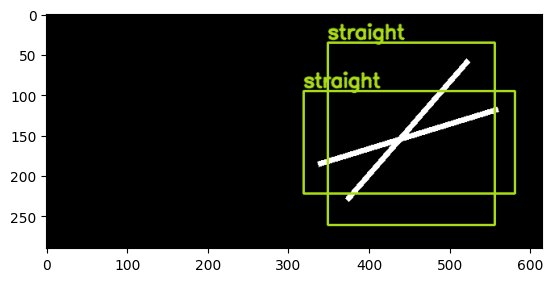

In [272]:
train_ds = RCNNImgDataset("strokes/data.pkl", STROKES, max_strokes=3, min_strokes=2)

res = train_ds[0]
boxes = res[1]["boxes"]
labels = res[1]["labels"]
image = (res[0].permute(1,2,0).numpy() * 255).astype(np.uint8)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
COLORS = np.random.uniform(0, 255, size=(len(STROKES), 3))
print(boxes)
print(labels)
for i, box in enumerate(boxes):
    color = COLORS[labels[i]]
    cv2.rectangle(
        image,
        (int(box[0]), int(box[1])),
        (int(box[2]), int(box[3])),
        color, 2
    )
    cv2.putText(image, STROKES[labels[i]], (int(box[0]), int(box[1]-5)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                lineType=cv2.LINE_AA)
plt.imshow(image)

In [275]:
# train_ds = RCNNImgDataset("strokes/data.pkl", STROKES)
# plt.imshow((train_ds[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8))
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
train_ds = RCNNImgDataset("strokes/data.pkl", STROKES, max_strokes=3, min_strokes=2)
device = torch.device("cpu")
def collate_fn(batch):
    imgs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    return imgs, labels
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = None

In [276]:
model.train()
for epoch in range(1):
    for images, targets in tqdm(train_dl):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            break

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()
